In [1]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import os

C:\Users\Onsiter\.conda\envs\nlp\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model_name = 'distilbert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

os.environ["WANDB_DISABLED"] = "true"

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier

## 1. Data Processing

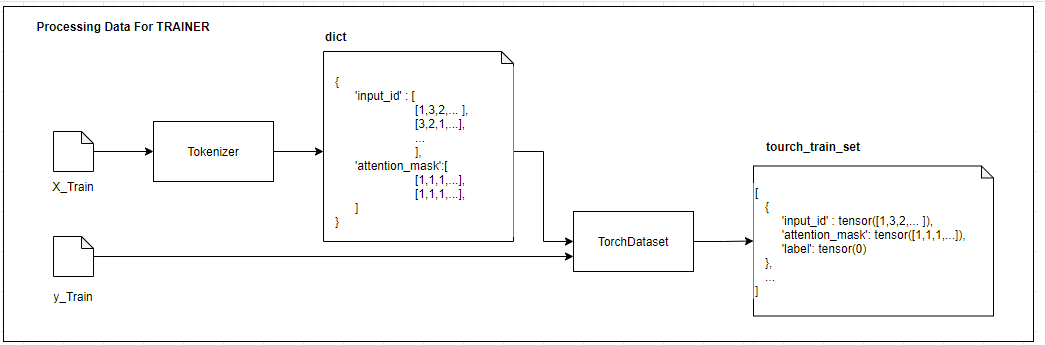

In [3]:
def load_data():
    """
    Load spam, split random data to Train, Test
    """
    df_raw = pd.read_csv("data/spam.csv", encoding='cp1252')[["v1", "v2"]]
    df_raw.rename(columns={"v1": "label", "v2": "sentences"}, inplace=True)

    # Encode label
    df_raw['label_encoded'] = df_raw.label.apply(lambda x: int(x=='spam'))

    # Split train and test
    X_train, X_test, y_train, y_test = train_test_split(df_raw["sentences"], df_raw["label_encoded"], test_size=0.2) 
    
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1)
    
    return df_raw, X_train.tolist(), X_val.tolist(), X_test.tolist(), y_train.tolist(), y_val.tolist(), y_test.tolist()


class TorchDataSet(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
        
        self.device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]).to(self.device) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).to(self.device)
        return item
    
    def __len__(self):
        return len(self.labels)

In [4]:
# Load and split data set
df_raw, X_train, X_val, X_test, y_train, y_val, y_test = load_data()

# Tokenizer X
tokenize_train = tokenizer(X_train, truncation=True, padding=True)
tokenize_val = tokenizer(X_val, truncation=True, padding=True)
tokenize_test = tokenizer(X_test, truncation=True, padding=True)

# Create Data set
torch_train_set = TorchDataSet(tokenize_train, y_train)
torch_val_set = TorchDataSet(tokenize_val, y_val)
torch_test_set = TorchDataSet(tokenize_test, y_val)

## 2. Fine-tuning

In [5]:
training_args = TrainingArguments(
    output_dir="results", 
    evaluation_strategy="epoch",
    per_device_train_batch_size=3,  # batch size per device during training
    per_device_eval_batch_size=3,   # batch size for evaluation
    dataloader_pin_memory=False     # Got ERROR relate to cannot pin 'torch.cuda.FloatTensor' only dense CPU tensors can be pinned. Removed this setting if you are not got the same error
    
)

Using the `WAND_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=torch_train_set,
    eval_dataset=torch_val_set,
    # logging_dir="./log"
)

trainer.train()

C:\Users\Onsiter\.conda\envs\nlp\lib\site-packages\transformers\optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4011
  Num Epochs = 3
  Instantaneous batch size per device = 3
  Total train batch size (w. parallel, distributed & accumulation) = 3
  Gradient Accumulation steps = 1
  Total optimization steps = 4011


Epoch,Training Loss,Validation Loss


Saving model checkpoint to results\checkpoint-500
Configuration saved in results\checkpoint-500\config.json


Attempted to log scalar metric loss:
0.1024
Attempted to log scalar metric learning_rate:
4.3767140363999005e-05
Attempted to log scalar metric epoch:
0.37


Model weights saved in results\checkpoint-500\pytorch_model.bin
Saving model checkpoint to results\checkpoint-1000
Configuration saved in results\checkpoint-1000\config.json


Attempted to log scalar metric loss:
0.1026
Attempted to log scalar metric learning_rate:
3.753428072799801e-05
Attempted to log scalar metric epoch:
0.75


Model weights saved in results\checkpoint-1000\pytorch_model.bin


## 3. Predict and evaluate

In [ ]:
out = trainer.predict(torch_test_set)

In [25]:
out.label_ids

array([0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
out.predictions

array([[ 7.6345205, -8.359074 ],
       [ 7.6147013, -8.346968 ],
       [ 7.5546374, -8.267267 ],
       [ 7.604041 , -8.367223 ],
       [ 5.0721536, -5.6135902],
       [-5.250854 ,  5.858702 ],
       [ 7.660727 , -8.369206 ],
       [ 7.427806 , -8.186454 ],
       [ 7.616889 , -8.372325 ],
       [ 7.5471196, -8.203858 ],
       [-5.2502174,  5.855975 ],
       [ 7.578126 , -8.3405285],
       [ 7.5185275, -8.284544 ],
       [ 7.7437067, -8.477866 ],
       [ 7.663892 , -8.414421 ],
       [-5.2498918,  5.8562274],
       [ 7.589204 , -8.326045 ],
       [ 7.194022 , -7.922475 ],
       [-5.2517033,  5.8587317],
       [ 7.5378   , -8.297657 ],
       [-5.252551 ,  5.859781 ],
       [ 7.3942204, -8.111136 ],
       [ 7.6039515, -8.355018 ],
       [-5.223846 ,  5.8220634],
       [-5.2486873,  5.854101 ],
       [ 7.7012453, -8.430389 ],
       [ 7.5400114, -8.287841 ],
       [ 7.6136665, -8.361971 ],
       [ 7.603157 , -8.390098 ],
       [ 7.554998 , -8.306894 ],
       [ 7